## โหลดรูปเบื้องต้น

In [16]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_lines")
output_folder.mkdir(exist_ok=True)

def face_detection(gray_img):
    face_cascade = cv2.CascadeClassifier('experiment_and_research/files/haarcascade_frontalface_default.xml')

    #จำแนกใบหน้า
    scaleFactor = 1.1
    minNeighber = 10
    face_detect = face_cascade.detectMultiScale(gray_img, scaleFactor, minNeighber)

    expand_ratio = 0.6  # อัตราส่วนการขยาย (50% ของขนาดเดิม)
    for (x, y, w, h) in face_detect:
        # คำนวณขนาดขยาย
        x_exp = int(x - expand_ratio * w)
        y_exp = int(y - expand_ratio * h)
        w_exp = int(w + 2 * (expand_ratio) * w)
        h_exp = int(h + 2 * (expand_ratio+0.3) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(gray_img.shape[1] - x_exp, w_exp)
        h_exp = min(gray_img.shape[0] - y_exp, h_exp)

        # วาดกรอบ
        cv2.rectangle(gray_img, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (255, 255, 255), thickness=-1)
        cv2.imwrite("../data/output_images/output/face_remove.jpg", gray_img)

    return gray_img

# โหลดภาพ
image = cv2.imread("../data/test_images/transcript/pun_20240817_0001.jpg")
#image = cv2.imread("../data/test_images/word_images/word_9.jpg")
#image = cv2.imread("../data/test_images/transcript/Transcript2.jpg")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray_img = face_detection(gray)

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

kernel = np.ones((5, 90), np.uint8)
lines = cv2.dilate(binary_image, kernel, iterations=1)

cv2.imwrite("../data/output_images/output/gary.jpg", gray_img)
cv2.imwrite("../data/output_images/output/binary.jpg", binary_image)
cv2.imwrite("../data/output_images/output/line.jpg", lines)

#kernel = np.ones((3,9), np.uint8)
dilalated_line_img = cv2.dilate(binary_image, kernel, iterations=1)

cv2.imwrite("../data/output_images/output/cca.jpg", image)

True

# จับกลุ่มข้อความ

36


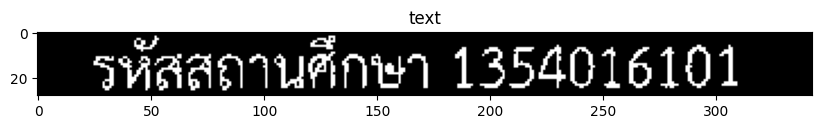

In [17]:
def detect_text_group(dilalated_image, binary_image):
    image = binary_image
    text_group_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dilalated_image, connectivity=8)

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.03
    for idx, i in enumerate(range(1, num_labels)):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stats[i]
        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(image.shape[1] - x_exp, w_exp)
        h_exp = min(image.shape[0] - y_exp, h_exp)

        if w >= 90 and h >= 20:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            cca_img = image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
            text_group_images.append(cca_img)
            cv2.imwrite(f"../data/output_images/output/cca_{idx}.jpg", cca_img)
            cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

    return text_group_images

text_group_images = detect_text_group(dilalated_line_img, binary_image)
#cv2.imwrite("../data/output_images/output/cca.jpg", image)
print(len(text_group_images))

plt.figure(figsize=(10,10))
plt.imshow(text_group_images[3], cmap="gray")
plt.title(f"text")
plt.show()


## จับข้อความย่อยในกลุ่มข้อความ

จำนวนกลุ่มข้อความ: 36
 จำนวนข้อความย่อยในกลุ่มข้อความ: 2


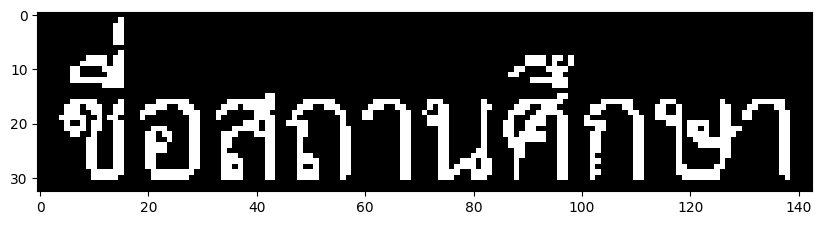

'\n# โหลดภาพ\nimg = cv2.imread("../data/output_images/output/cca_29.jpg")\n\n# แปลงเป็น Grayscale\ngray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n\n# การ Threshold แบบ Adaptive Gaussian\nbinary_image = cv2.adaptiveThreshold(\n    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30\n)\n\ncv2.imshow("image", binary_image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n\nkernel = np.ones((4, 9), np.uint8)\ndummy_word_image = cv2.dilate(binary_image, kernel, iterations=1)\n\n# ใช้ Connected Component Analysis\nnum_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_word_image, connectivity=8)\n\n# จัดเรียงจากซ้ายไปขวา (ตามค่า x)\nsorted_indices = np.argsort(stats[1:, 0])  # ข้าม background (index 0)\nsorted_stats = stats[1:][sorted_indices]  # จัดเรียง stats ใหม่\nsorted_centroids = centroids[1:][sorted_indices]  # จัดเรียง centroids ใหม่\n\n\nexpand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)\nreduce_size = 0.00\n# วาดกรอบตามลำดับ\

In [43]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def detect_text_in_group(binary_image):
    kernel = np.ones((4, 9), np.uint8)
    dummy_image = cv2.dilate(binary_image, kernel, iterations=1)

    sub_text_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00
    for idx, i in enumerate(range(1, num_labels)):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stats[i]
        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(binary_image.shape[1] - x_exp, w_exp)
        h_exp = min(binary_image.shape[0] - y_exp, h_exp)

        cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
        sub_text_images.append(cca_img)
        cv2.imwrite(f"../data/output_images/output/text_sub/cca_{idx}.jpg", cca_img)
        cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

    return sub_text_images 

#text_images = detect_text_in_group(dilalated_img, binary_image)

text_group_sub_images = []
for idx_text, text_group in enumerate(text_group_images):
    #print(idx_text)
    text_group_sub_images.append(detect_text_in_group(text_group))

print("จำนวนกลุ่มข้อความ:", len(text_group_sub_images)) 
print(" จำนวนข้อความย่อยในกลุ่มข้อความ:", len(text_group_sub_images[2]))  

plt.figure(figsize=(10,10))
plt.imshow(text_group_sub_images[2][0], cmap="gray")
#plt.title(f"text")
plt.show()

'''
# โหลดภาพ
img = cv2.imread("../data/output_images/output/cca_29.jpg")

# แปลงเป็น Grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

cv2.imshow("image", binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

kernel = np.ones((4, 9), np.uint8)
dummy_word_image = cv2.dilate(binary_image, kernel, iterations=1)

# ใช้ Connected Component Analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_word_image, connectivity=8)

# จัดเรียงจากซ้ายไปขวา (ตามค่า x)
sorted_indices = np.argsort(stats[1:, 0])  # ข้าม background (index 0)
sorted_stats = stats[1:][sorted_indices]  # จัดเรียง stats ใหม่
sorted_centroids = centroids[1:][sorted_indices]  # จัดเรียง centroids ใหม่


expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
reduce_size = 0.00
# วาดกรอบตามลำดับ
print(f'-----------------------------------------')
for idx, stat in enumerate(sorted_stats):
    #print(f'{idx} {stat}, x+y:{(stat[0]+stat[1])}, y+h:{(stat[1]+stat[3])}, x+w:{(stat[0]+stat[2])}')
    x, y, w, h, area = stat
    x_exp = int(x - (expand_ratio-reduce_size) * w)
    y_exp = int(y - (expand_ratio) * h)
    w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
    h_exp = int(h + 2 * (expand_ratio) * h)

    # ตรวจสอบไม่ให้เกินขอบภาพ
    x_exp = max(0, x_exp)
    y_exp = max(0, y_exp)
    w_exp = min(img.shape[1] - x_exp, w_exp)
    h_exp = min(img.shape[0] - y_exp, h_exp)

    cca_img = img[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]

    cv2.imwrite(f"../data/output_images/output/word/cca_word_{idx}.jpg", cca_img)
    cv2.rectangle(img, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)
    #print(f"Component {idx}: x={x}, y={y}, w={w}, h={h}, area={area}")

cv2.imwrite("../data/output_images/output/word/cca.jpg", img)

'''


## จับตัวอักษร

In [82]:
# โหลดภาพ
image = cv2.imread("../data/test_images/char_level/char_4.jpg")

if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray_img = face_detection(gray)

# การ Threshold แบบ Adaptive Gaussian
binary_image_test = cv2.adaptiveThreshold(
    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

import numpy as np

def sort_and_swap(stats):

    if(len(stats) > 1):
        """
        จัดเรียงข้อมูลใน stats โดยเรียงจาก y + h (มากไปน้อย)
        และตรวจสอบว่าข้อมูลที่มี area ใหญ่ที่สุดอยู่ในตำแหน่งแรกสุดหรือไม่
        """
        # คำนวณค่า y + h สำหรับการจัดเรียง
        stats_with_indices = [(i, stat) for i, stat in enumerate(stats)]
        stats_with_indices.sort(key=lambda x: x[1][1] + x[1][3], reverse=True)  # y + h (มาก -> น้อย)

        # สร้างลิสต์ใหม่หลังการจัดเรียง
        sorted_stats = [stat for _, stat in stats_with_indices]

        # หาค่า area ที่ใหญ่ที่สุดและตำแหน่ง
        areas = [stat[4] for stat in sorted_stats]  # ค่า area อยู่ใน index ที่ 4
        max_area = max(areas)
        max_area_index = areas.index(max_area)

        # ตรวจสอบว่า area ที่ใหญ่ที่สุดอยู่ตำแหน่งแรกหรือไม่
        if max_area_index != 0:
            # สลับตำแหน่งตัวที่มี area ใหญ่ที่สุดกับตัวแรก
            sorted_stats[0], sorted_stats[max_area_index] = sorted_stats[max_area_index], sorted_stats[0]

        print("มีหลายอัน")
        return sorted_stats
    else:
        print("อันเดียว")
        return stats



def char_level(char_image):
    kernel = np.ones((1, 1), np.uint8)
    dummy_image = cv2.dilate(char_image, kernel, iterations=1)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)

    sorted_stats = sort_and_swap(stats[1:])

    char_level_group = []
    
    #for idx, i in enumerate(test):
    ##   print(area)

    for idx, stats in enumerate(sorted_stats):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stats

        cca_img = char_image[y:y+h, x:x+w]
        char_level_group.append(cca_img)
        cv2.imwrite(f"../data/test_images/char_level/cca_{idx}.jpg", cca_img)
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
        #cv2.imwrite(f"../data/test_images/char_level/dummy_image.jpg", dummy_image)

    print(f"Number of characters detected: {len(char_level_group)}")
    return char_level_group 

char_level(binary_image_test)
cv2.imwrite(f"../data/test_images/char_level/cca.jpg", image)

'''
cv2.imshow("test", binary_image_test)
cv2.waitKey(0)
cv2.destroyAllWindows()
'''

    

def detect_char(binary_image):
    kernel = np.ones((3, 1), np.uint8)
    dummy_image = cv2.dilate(binary_image, kernel, iterations=1)

    char_images = []
    # ใช้ Connected Component Analysis
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_image, connectivity=8)

    expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
    reduce_size = 0.00
    for idx, i in enumerate(range(1, num_labels)):  # เริ่มจาก 1 เพราะ 0 คือ background
        x, y, w, h, area = stats[i]
        x_exp = int(x - (expand_ratio-reduce_size) * w)
        y_exp = int(y - (expand_ratio) * h)
        w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
        h_exp = int(h + 2 * (expand_ratio) * h)

        # ตรวจสอบไม่ให้เกินขอบภาพ
        x_exp = max(0, x_exp)
        y_exp = max(0, y_exp)
        w_exp = min(binary_image.shape[1] - x_exp, w_exp)
        h_exp = min(binary_image.shape[0] - y_exp, h_exp)

        cca_img = binary_image[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]
        char_images.append(cca_img)
        #cv2.imwrite(f"../data/output_images/output/text_sub/cca_{idx}.jpg", cca_img)
        cv2.rectangle(image, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)

    return char_images 

'''
for idx_group, text_group in enumerate(text_group_sub_images):
    print("กลุ่มข้อความที่:", idx_group+1)

    char_in_sub_text = []
    for idx_sup, sub_text in enumerate(text_group):
        print("   ข้อความย่อยที่:", idx_sup+1)
        detect_char(sub_text)
        #for idx_char, char in enumerate(text_sup):
            #print("    อักษรที่:", idx_char+1)
'''


'''
# โหลดภาพ
img = cv2.imread("../data/output_images/output/word/cca_word_0.jpg")

# แปลงเป็น Grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

kernel = np.ones((3, 1), np.uint8)
dummy_char_image = cv2.dilate(binary_image, kernel, iterations=1)


cv2.imshow("image", dummy_char_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# ใช้ Connected Component Analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_char_image, connectivity=8)

# จัดเรียงจากซ้ายไปขวา (ตามค่า x)
sorted_indices = np.argsort(stats[1:, 0])  # ข้าม background (index 0)
sorted_stats = stats[1:][sorted_indices]  # จัดเรียง stats ใหม่
sorted_centroids = centroids[1:][sorted_indices]  # จัดเรียง centroids ใหม่

expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
reduce_size = 0.00

for idx, stat in enumerate(sorted_stats):
    #print(f'{idx} {stat}, x+y:{(stat[0]+stat[1])}, y+h:{(stat[1]+stat[3])}, x+w:{(stat[0]+stat[2])}')
    x, y, w, h, area = stat
    x_exp = int(x - (expand_ratio-reduce_size) * w)
    y_exp = int(y - (expand_ratio) * h)
    w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
    h_exp = int(h + 2 * (expand_ratio) * h)

    # ตรวจสอบไม่ให้เกินขอบภาพ
    x_exp = max(0, x_exp)
    y_exp = max(0, y_exp)
    w_exp = min(img.shape[1] - x_exp, w_exp)
    h_exp = min(img.shape[0] - y_exp, h_exp)

    cca_img = img[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]

    cv2.imwrite(f"../data/output_images/output/word/char/cca_char_{idx}.jpg", cca_img)
    cv2.rectangle(img, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)
    #print(f"Component {idx}: x={x}, y={y}, w={w}, h={h}, area={area}")

cv2.imwrite("../data/output_images/output/word/char/cca.jpg", img)
'''


มีหลายอัน
Number of characters detected: 3


'\n# โหลดภาพ\nimg = cv2.imread("../data/output_images/output/word/cca_word_0.jpg")\n\n# แปลงเป็น Grayscale\ngray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n\n# การ Threshold แบบ Adaptive Gaussian\nbinary_image = cv2.adaptiveThreshold(\n    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30\n)\n\nkernel = np.ones((3, 1), np.uint8)\ndummy_char_image = cv2.dilate(binary_image, kernel, iterations=1)\n\n\ncv2.imshow("image", dummy_char_image)\ncv2.waitKey(0)\ncv2.destroyAllWindows()\n\n\n# ใช้ Connected Component Analysis\nnum_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(dummy_char_image, connectivity=8)\n\n# จัดเรียงจากซ้ายไปขวา (ตามค่า x)\nsorted_indices = np.argsort(stats[1:, 0])  # ข้าม background (index 0)\nsorted_stats = stats[1:][sorted_indices]  # จัดเรียง stats ใหม่\nsorted_centroids = centroids[1:][sorted_indices]  # จัดเรียง centroids ใหม่\n\nexpand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)\nreduce_size = 0.00\n\nf

In [ ]:
# โหลดภาพ
img = cv2.imread("../data/output_images/output/word/char/cca_char_6.jpg")

# แปลงเป็น Grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

#kernel = np.ones((2, 2), np.uint8)
#dummy_char_image = cv2.dilate(binary_image, kernel, iterations=1)
#dummy_char_image = cv2.erode(binary_image, kernel, iterations=1)

cv2.imshow("image", binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# ใช้ Connected Component Analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_image, connectivity=8)

# จัดเรียงจากซ้ายไปขวา (ตามค่า x)
sorted_indices = np.argsort(stats[1:, 0])  # ข้าม background (index 0)
sorted_stats = stats[1:][sorted_indices]  # จัดเรียง stats ใหม่
sorted_centroids = centroids[1:][sorted_indices]  # จัดเรียง centroids ใหม่

expand_ratio = 0.0  # อัตราส่วนการขยาย (0.5 คือ 50% ของขนาดเดิม)
reduce_size = 0.00

for idx, stat in enumerate(sorted_stats):
    #print(f'{idx} {stat}, x+y:{(stat[0]+stat[1])}, y+h:{(stat[1]+stat[3])}, x+w:{(stat[0]+stat[2])}')
    x, y, w, h, area = stat

    x_exp = int(x - (expand_ratio-reduce_size) * w)
    y_exp = int(y - (expand_ratio) * h)
    w_exp = int(w + 2 * (expand_ratio-reduce_size) * w)
    h_exp = int(h + 2 * (expand_ratio) * h)

    # ตรวจสอบไม่ให้เกินขอบภาพ
    x_exp = max(0, x_exp)
    y_exp = max(0, y_exp)
    w_exp = min(img.shape[1] - x_exp, w_exp)
    h_exp = min(img.shape[0] - y_exp, h_exp)

    cca_img = img[y_exp:y_exp+h_exp, x_exp:x_exp+w_exp]

    cv2.imwrite(f"../data/output_images/output/word/char/char_level/cca_level_{idx}.jpg", cca_img)
    cv2.rectangle(img, (x_exp, y_exp), (x_exp + w_exp, y_exp + h_exp), (0, 255, 0), 1)
    #print(f"Component {idx}: x={x}, y={y}, w={w}, h={h}, area={area}")

cv2.imwrite("../data/output_images/output/word/char/char_level/cca.jpg", img)